# Figures pour le projet ALLOGENOMICS

## Import des modules nécessaires

In [1]:
#coding:utf-8
import os
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
import glob
import re
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
import seaborn as sns

import table_operations as table_ops

import time
from datetime import date

/home/pierre/miniconda3/bin/python3
3.9.5 (default, Jun  4 2021, 12:28:51) 
[GCC 7.5.0]
sys.version_info(major=3, minor=9, micro=5, releaselevel='final', serial=0)


## Chargement des données

In [3]:
clinical_csh = pd.read_csv("~/Documents/AMS_workflow/output/indiv_vcf/joint_genotyping/hard-filtered/csh_clinical_ams.csv")

In [4]:
acute = clinical_csh[clinical_csh["GVH_status"]=="acute_only"].reset_index(drop=True)
chronic = clinical_csh[clinical_csh["GVH_status"]=="chronic_only"].reset_index(drop=True)
no_gvh = clinical_csh[clinical_csh["GVH_status"]=="no_gvh"].reset_index(drop=True)
acute_large = clinical_csh[(clinical_csh["GVH_status"]=="acute_only")|(clinical_csh["GVH_status"]=="no_gvh")].reset_index(drop=True)
chronic_large = clinical_csh[(clinical_csh["GVH_status"]=="chronic_only")|(clinical_csh["GVH_status"]=="no_gvh")].reset_index(drop=True)

## Calcul des statistiques de T-test

### AMS

In [5]:
stat_acute,pval_acute = stats.ttest_ind(acute_large[acute_large["GVH_status"]=="acute_only"]["AMS_stop"],
                                        acute_large[acute_large["GVH_status"]=="no_gvh"]["AMS_stop"])
stat_chronic,pval_chronic = stats.ttest_ind(chronic_large[chronic_large["GVH_status"]=="chronic_only"]["AMS_stop"],
                                            chronic_large[chronic_large["GVH_status"]=="no_gvh"]["AMS_stop"])
print(pval_acute)
print(pval_chronic)

0.4064803418088623
0.748447551918348


### AAMS WeakBinder+StrongBinder (EL_threshold <= 2%)

In [6]:
stat_acute_2,pval_acute_2 = stats.ttest_ind(acute_large[acute_large["GVH_status"]=="acute_only"]["AAMS_EL2"],
                                            acute_large[acute_large["GVH_status"]=="no_gvh"]["AAMS_EL2"])
stat_chronic_2,pval_chronic_2 = stats.ttest_ind(chronic_large[chronic_large["GVH_status"]=="chronic_only"]["AAMS_EL2"],
                                                chronic_large[chronic_large["GVH_status"]=="no_gvh"]["AAMS_EL2"])
print(pval_acute_2)
print(pval_chronic_2)

0.36887806452563865
0.665782617774556


### AAMS StrongBinder (EL_threshold <= 0.5%)

In [7]:
stat_acute_05,pval_acute_05 = stats.ttest_ind(acute_large[acute_large["GVH_status"]=="acute_only"]["AAMS_EL05"],
                                              acute_large[acute_large["GVH_status"]=="no_gvh"]["AAMS_EL05"])
stat_chronic_05,pval_chronic_05 = stats.ttest_ind(chronic_large[chronic_large["GVH_status"]=="chronic_only"]["AAMS_EL05"],
                                                  chronic_large[chronic_large["GVH_status"]=="no_gvh"]["AAMS_EL05"])
print(pval_acute_05)
print(pval_chronic_05)

0.5322450943722972
0.8454477603218503


## Student's T Test

On simplifie le modèle en prenant N comme proportion de n1 et n2, basé sur le nombre d'individus observés. 
Pour exemple, pour la comparaison GVH chronique / pas de GVH, on a n1 = 8 individus présentant de la GVH chronique et n2 = 16 individus ne présentant pas de GVH.

In [10]:
def custom_t_test(df,condition,score_column,force,N_max,alpha,tail,thresh):
    sample_1 = df[df["GVH_status"]==condition][score_column]
    sample_2 = df[df["GVH_status"]=="no_gvh"][score_column]
    mean1,mean2 = sample_1.mean(),sample_2.mean()
    n1,n2 = len(sample_1),len(sample_2)
    prop_n1, prop_n2 = n1/(n1+n2),n2/(n1+n2)
    std_error = df[score_column].std()
    ls_N = np.arange(1,N_max+1)
    dict_pval = {}
    for N in ls_N :
        t_obs = force*abs(mean1-mean2)/(std_error/np.sqrt(N))
        t_crit = stats.t.ppf(q=thresh,df=N-1)
        pval = tail*(stats.t.sf(x=t_obs,df=N-1))
        dict_pval[N] = (pval,prop_n1*N,prop_n2*N)
    return(dict_pval)

### AMS

In [11]:
acutes_ams_1 = []
chronics_ams_1 = []
acutes_ams_2 = []
chronics_ams_2 = []
forces = [1,1.1,2,5]
for i in forces:
    acute_ams_dict_1 = custom_t_test(acute_large,"acute_only","AMS_stop",i,500,0.05,1,0.95)
    chronic_ams_dict_1 = custom_t_test(chronic_large,"chronic_only","AMS_stop",i,500,0.05,1,0.95)
    acute_ams_dict_2 = custom_t_test(acute_large,"acute_only","AMS_stop",i,500,0.05,2,0.975)
    chronic_ams_dict_2 = custom_t_test(chronic_large,"chronic_only","AMS_stop",i,500,0.05,2,0.975)
    acutes_ams_1.append(acute_ams_dict_1)
    chronics_ams_1.append(chronic_ams_dict_1)
    acutes_ams_2.append(acute_ams_dict_2)
    chronics_ams_2.append(chronic_ams_dict_2)
print(acutes_ams_1[0][31])
print(chronics_ams_1[0][24])
print(acutes_ams_2[0][31])
print(chronics_ams_2[0][24])

(0.05033001271850743, 15.0, 16.0)
(0.2446558030629939, 8.0, 16.0)
(0.10066002543701486, 15.0, 16.0)
(0.4893116061259878, 8.0, 16.0)


### AAMS WeakBinder+StrongBinder (EL_threshold <= 2%)

In [12]:
acutes_aams_el2_1 = []
chronics_aams_el2_1 = []
acutes_aams_el2_2 = []
chronics_aams_el2_2 = []
for i in forces:
    acute_aams_el2_dict_1 = custom_t_test(acute_large,"acute_only","AAMS_EL2",i,500,0.05,1,0.95)
    chronic_aams_el2_dict_1 = custom_t_test(chronic_large,"chronic_only","AAMS_EL2",i,500,0.05,1,0.95)
    acute_aams_el2_dict_2 = custom_t_test(acute_large,"acute_only","AAMS_EL2",i,500,0.05,2,0.975)
    chronic_aams_el2_dict_2 = custom_t_test(chronic_large,"chronic_only","AAMS_EL2",i,500,0.05,2,0.975)
    acutes_aams_el2_1.append(acute_aams_el2_dict_1)
    chronics_aams_el2_1.append(chronic_aams_el2_dict_1)
    acutes_aams_el2_2.append(acute_aams_el2_dict_2)
    chronics_aams_el2_2.append(chronic_aams_el2_dict_2)
print(acutes_aams_el2_1[0][31])
print(acutes_aams_el2_2[0][31])
print(chronics_aams_el2_1[0][24])
print(chronics_aams_el2_2[0][24])

(0.03847618863621276, 15.0, 16.0)
(0.07695237727242552, 15.0, 16.0)
(0.17710892541362067, 8.0, 16.0)
(0.35421785082724133, 8.0, 16.0)


### AAMS StrongBinder (EL_threshold <= 0.5%)

In [13]:
acutes_aams_el05_1 = []
chronics_aams_el05_1 = []
acutes_aams_el05_2 = []
chronics_aams_el05_2 = []
for i in forces:
    acute_aams_el05_dict_1 = custom_t_test(acute_large,"acute_only","AAMS_EL05",i,500,0.05,1,0.95)
    chronic_aams_el05_dict_1 = custom_t_test(chronic_large,"chronic_only","AAMS_EL05",i,500,0.05,1,0.95)
    acute_aams_el05_dict_2 = custom_t_test(acute_large,"acute_only","AAMS_EL05",i,500,0.05,2,0.975)
    chronic_aams_el05_dict_2 = custom_t_test(chronic_large,"chronic_only","AAMS_EL05",i,500,0.05,2,0.975)
    acutes_aams_el05_1.append(acute_aams_el05_dict_1)
    chronics_aams_el05_1.append(chronic_aams_el05_dict_1)
    acutes_aams_el05_2.append(acute_aams_el05_dict_2)
    chronics_aams_el05_2.append(chronic_aams_el05_dict_2)
print(acutes_aams_el05_1[0][31])
print(chronics_aams_el05_1[0][24])
print(acutes_aams_el05_2[0][31])
print(chronics_aams_el05_2[0][24])

(0.1055601190488955, 15.0, 16.0)
(0.3365159217528298, 8.0, 16.0)
(0.211120238097791, 15.0, 16.0)
(0.6730318435056596, 8.0, 16.0)


In [46]:
lst = [acutes_ams_1,chronics_ams_1,acutes_ams_2,chronics_ams_2,acutes_aams_el2_1,chronics_aams_el2_1,acutes_aams_el2_2,chronics_aams_el2_2,acutes_aams_el05_1,chronics_aams_el05_1,acutes_aams_el05_2,chronics_aams_el05_2]
test2 = []
count = 0
count2 = 0
st = 0
for j in range(len(lst)):
    count2+=1
    for i in range(len(lst[j])) :
        test=[]
        for key in lst[j][i]:
            if count2 <=4:
#                 print("run {}, count2 = {}".format(st,count2))
                typ = "AMS"
            elif 4 < count2 <=8:
#                 print("run {}, count2 = {}".format(st,count2))
                typ = "AAMS_EL2"
            else:
#                 print("run {}, count2 = {}".format(st,count2))
                typ = "AAMS_EL05"
            if count <2 :
                t = "one-tail"
            else:
                t = "two-tail"
            if j%2==0:
#                 print(st,count,count2,j)
                test.append(pd.DataFrame([list(lst[j][i][key])+[key,forces[i],"acute_GVH",t,typ]],columns=["pval","n1","n2","N","forces","condition","test","mismatch"]))
            else:
                test.append(pd.DataFrame([list(lst[j][i][key])+[key,forces[i],"chronic GVH",t,typ]],columns=["pval","n1","n2","N","forces","condition","test","mismatch"]))
            st +=1
        test2.append(pd.concat(test))
    if count <3:
        count+=1
    else:
        count=0

res = pd.concat(test2)
res.to_csv("../../output/indiv_vcf/joint_genotyping/hard-filtered/test_this_dataframe.csv",index=False)

In [48]:
res.head()

,pval,n1,n2,N,forces,condition,test,mismatch
0,NaN,0.483871,0.516129,1,1.0,acute_GVH,one-tail,AMS
0,0.370673,0.967742,1.032258,2,1.0,acute_GVH,one-tail,AMS
0,0.325429,1.451613,1.548387,3,1.0,acute_GVH,one-tail,AMS
0,0.292936,1.935484,2.064516,4,1.0,acute_GVH,one-tail,AMS
0,0.266840,2.419355,2.580645,5,1.0,acute_GVH,one-tail,AMS


## Plots

### General p-values

In [51]:
def plot_pvalues(acutes_dict_list,chronics_dict_list,forces=[],alpha=0.01):
    # define subplot
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    # check if forces was given as arg
    if forces != []:
        # in that case, plot all lines corresponding
        for i in range(len(acutes_dict_list)):
            # one plot for each group
            ax1.plot(acutes_dict_list[i].keys(),[np.log10(tup[0]) for tup in list(acutes_dict_list[i].values())],
                     label="Dmean = {}*(mean1-mean2)".format(forces[i]))
            ax2.plot(chronics_dict_list[i].keys(),[np.log10(tup[0]) for tup in list(chronics_dict_list[i].values())],
                     label="Dmean = {}*(mean1-mean2)".format(forces[i]))
    # otherwise only plot the one with observed mean difference
    else:
        ax1.plot(acutes_dict_list[0].keys(),[np.log10(tup[0]) for tup in list(acutes_dict_list[0].values())])
        ax2.plot(chronics_dict_list[0].keys(),[np.log10(tup[0]) for tup in list(chronics_dict_list[0].values())])
    # plot line with the minimal significative p-value
    ax1.axhline(y=np.log10(alpha),c="r",label="p-value threshold = {}".format(alpha))
    ax1.title.set_text("GVHa vs noGVH avec une base n1=15 et n2=16")
    ax1.set_ylabel("log10(pval)")
    ax1.legend()
    ax2.axhline(y=np.log10(alpha),c="r",label="p-value threshold = {}".format(alpha))
    ax2.title.set_text("GVHc vs noGVH avec une base n1=8 et n2=16")
    ax2.set_ylabel("log10(pval)")
    ax2.legend()
    fig.suptitle("Estimation du nombre de paires nécessaires pour avoir une différence de moyennes significative")
    fig.supxlabel("Nombre de paires, définies en proportion n1 et n2")
    plt.show()

#### AMS

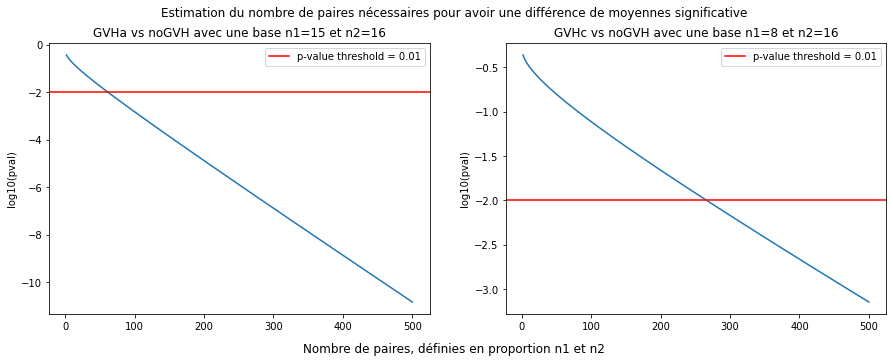

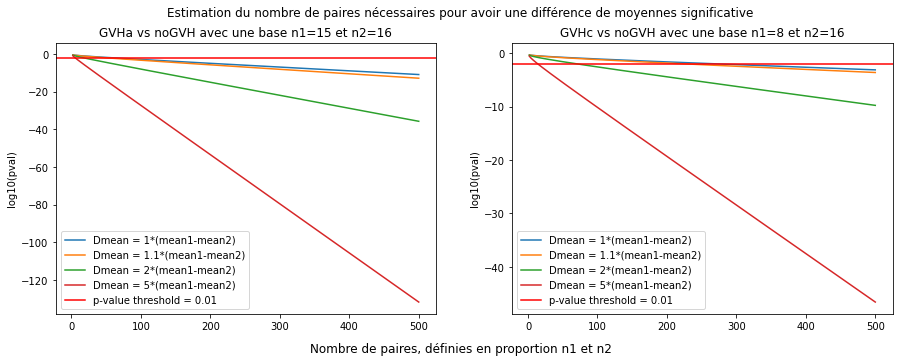

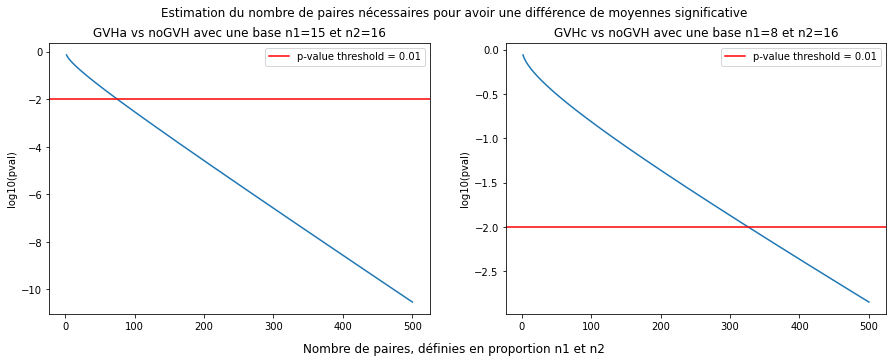

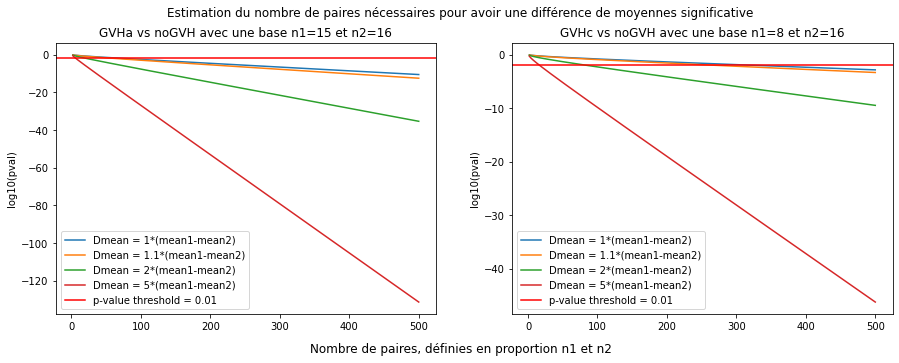

In [52]:
plot_pvalues(acutes_ams_1,chronics_ams_1)
plot_pvalues(acutes_ams_1,chronics_ams_1,forces)
plot_pvalues(acutes_ams_2,chronics_ams_2)
plot_pvalues(acutes_ams_2,chronics_ams_2,forces)

#### AAMS WeakBinder+StrongBinder (EL_threshold <= 2%)

In [ ]:
plot_pvalues(acutes_aams_el2_2,chronics_aams_el2_2)
plot_pvalues(acutes_aams_el2_2,chronics_aams_el2_2,forces)
plot_pvalues(acutes_aams_el2_1,chronics_aams_el2_1)
plot_pvalues(acutes_aams_el2_1,chronics_aams_el2_1,forces)

#### AAMS StrongBinder (EL_threshold <= 0.5%)

In [ ]:
plot_pvalues(acutes_aams_el05_2,chronics_aams_el05_2)
plot_pvalues(acutes_aams_el05_2,chronics_aams_el05_2,forces)

### Zoom sur les p-values inférieures à 0.1

#### Sélection des p-values

In [ ]:
def dict_filtering(dict_pvalues,up,down):
    not_nan_pvalues = {k:v for k,v in dict_pvalues.items() if not np.isnan(v[0])}
    filtered_pvalues = {key:value for key,value in not_nan_pvalues.items() if up <= value[0] <= down}
    return(filtered_pvalues)

#### AMS

In [ ]:
filtered_acutes_ams_1 = []
filtered_chronics_ams_1 = []
filtered_acutes_ams_2 = []
filtered_chronics_ams_2 = []
for i in range(len(acutes_ams)):
    filtered_acute_ams_1 = dict_filtering(acutes_ams_1[i],1e-5,1e-1)
    filtered_chronic_ams_1 = dict_filtering(chronics_ams_1[i],1e-5,1e-1)
    filtered_acutes_ams_1.append(filtered_acute_ams_1)
    filtered_chronics_ams_1.append(filtered_chronic_ams_1)
    filtered_acute_ams_2 = dict_filtering(acutes_ams_2[i],1e-5,1e-1)
    filtered_chronic_ams_2 = dict_filtering(chronics_ams_2[i],1e-5,1e-1)
    filtered_acutes_ams_2.append(filtered_acute_ams_2)
    filtered_chronics_ams_2.append(filtered_chronic_ams_2)

plot_pvalues(filtered_acutes_ams_2,chronics_ams_2)
plot_pvalues(filtered_acutes_ams_2,chronics_ams_2,forces)

#### AAMS WeakBinder+StrongBinder (EL_threshold <= 2%)

In [ ]:
filtered_acutes_aams_el2_1 = []
filtered_chronics_aams_el2_1 = []
for i in range(len(acutes_ams)):
    filtered_acute_aams_el2_1 = dict_filtering(acutes_aams_el2_1[i],1e-5,1e-1)
    filtered_chronic_aams_el2_1 = dict_filtering(chronics_aams_el2_1[i],1e-5,1e-1)
    filtered_acutes_aams_el2_1.append(filtered_acute_aams_el2_1)
    filtered_chronics_aams_el2_1.append(filtered_chronic_aams_el2_1)

plot_pvalues(filtered_acutes_aams_el2_1,filtered_chronics_aams_el2_1)
plot_pvalues(filtered_acutes_aams_el2_1,filtered_chronics_aams_el2_1,forces)

#### AAMS StrongBinder (EL_threshold <= 0.5%)

In [ ]:
filtered_acutes_aams_el05_1 = []
filtered_chronics_aams_el05_1 = []
filtered_acutes_aams_el05_2 = []
filtered_chronics_aams_el05_2 = []
for i in range(len(acutes_ams)):
    filtered_acute_aams_el05_1 = dict_filtering(acutes_aams_el05_1[i],1e-5,1e-1)
    filtered_chronic_aams_el05_1 = dict_filtering(chronics_aams_el05_1[i],1e-5,1e-1)
    filtered_acutes_aams_el05_1.append(filtered_acute_aams_el05_1)
    filtered_chronics_aams_el05_1.append(filtered_chronic_aams_el05_1)
    filtered_acute_aams_el05_2 = dict_filtering(acutes_aams_el05_2[i],1e-5,1e-1)
    filtered_chronic_aams_el05_2 = dict_filtering(chronics_aams_el05_2[i],1e-5,1e-1)
    filtered_acutes_aams_el05_2.append(filtered_acute_aams_el05_2)
    filtered_chronics_aams_el05_2.append(filtered_chronic_aams_el05_2)

plot_pvalues(filtered_acutes_aams_el05_2,filtered_chronics_aams_el05_2)
plot_pvalues(filtered_acutes_aams_el05_2,filtered_chronics_aams_el05_2,forces)
plot_pvalues(filtered_acutes_aams_el05_1,filtered_chronics_aams_el05_1)
plot_pvalues(filtered_acutes_aams_el05_1,filtered_chronics_aams_el05_1,forces)

## Nanopore Coverage

### Chargement des données

In [ ]:
plt.style.use("ggplot")
bedfile_np = pd.read_csv("~/Documents/AMS_workflow/output/runs/AMS_twist_giab/run_tables/flanks_concat_twist.tsv",sep="\t")

In [ ]:
print(bedfile_np.head())

In [ ]:
plt.scatter(bedfile_np["flank_size"].unique().tolist(),bedfile_np["median_interval"].unique().tolist(),s=20)
plt.plot(bedfile_np["flank_size"].unique().tolist(),bedfile_np["median_interval"].unique().tolist())
plt.title("Taille regions flanquantes vs intervalle moyen")
plt.xlabel("flank_size")
plt.ylabel("mean_interval")
plt.show()

In [ ]:
plt.scatter(bedfile_np["flank_size"].unique().tolist(),bedfile_np["median_interval"].unique().tolist(),s=20)
plt.plot(bedfile_np["flank_size"].unique().tolist(),bedfile_np["median_interval"].unique().tolist())
plt.title("Taille regions flanquantes vs intervalle median")
plt.xlabel("flank_size")
plt.ylabel("median_interval")
plt.show()

In [ ]:
plt.scatter(bedfile_np["flank_size"].unique().tolist(),bedfile_np["genome_cov"].unique().tolist(),s=20)
plt.plot(bedfile_np["flank_size"].unique().tolist(),bedfile_np["genome_cov"].unique().tolist())
plt.title("Taille regions flanquantes vs couverture genomique")
plt.xlabel("flank_size")
plt.ylabel("genome_cov")
plt.show()

In [ ]:
plt.scatter(bedfile_np["median_interval"].unique().tolist(),bedfile_np["genome_cov"].unique().tolist(),s=20)
plt.plot(bedfile_np["median_interval"].unique().tolist(),bedfile_np["genome_cov"].unique().tolist())
plt.title("Taille intervalle median vs couverture genomique")
plt.xlabel("median_interval")
plt.ylabel("genome_cov")
plt.show()